In [1]:
'''

Activating session for tensorflow 2 GPU 
Tensroflow 2 with nvidia 3070RTX

''' 
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

'''

Importing Packages

'''

from PIL import Image    
import os, glob
import sys
import json
import datetime
import numpy as np
import skimage.draw
import shutil
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize as vis
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt


'''

Json Parsing class

'''


class GenericDataset(utils.Dataset):

    def load_item(self, dataset_dir, subset):
        """Load a subset of dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys



        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        classes = []

        all_files = dict()
        for _ in os.listdir(dataset_dir):
#             print(".".join(_.split(".")[:-1]))
#             all_files[".".join(_.split(".")[:-1])] = _ 
            
            all_files[_] = _ 
        for a in annotations:
            
            polygons=[]
            objects=[]
            for r in a['regions']:
                polygons.append(r['shape_attributes'])
                objects.append(r['region_attributes'])

            class_ids = [int(n['class']) for n in objects]
            image_path = dataset_dir + "/" + all_files[a['filename'] ]
            image = Image.open(image_path)
            width, height = image.size
            
            
            self.add_image(
                "class",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)
            
            
            for r in a['regions']:
                _class = r['region_attributes']['class']
                if _class not in classes:
                    classes += [_class]
                    self.add_class("class", _class,  str(_class))
        

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1


        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids



Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



## 1. Loading Dataset

In [4]:
"""Build Dataset."""
print("Loading Training Dataset...")
DATASET_DIR = "/media/sohaib/additional_/DataScience/knee_mri/dataset/mrcnn_format/"

# Training dataset.
dataset_train = GenericDataset()
dataset_train.load_item(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
print("Loading Validation Dataset...")
dataset_val = GenericDataset()
dataset_val.load_item(DATASET_DIR, "val")
dataset_val.prepare()

Loading Training Dataset...
12548
Loading Validation Dataset...
5664



## 3. Ploting samples

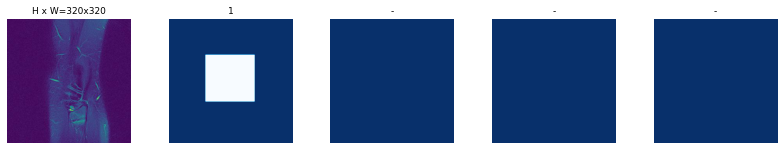

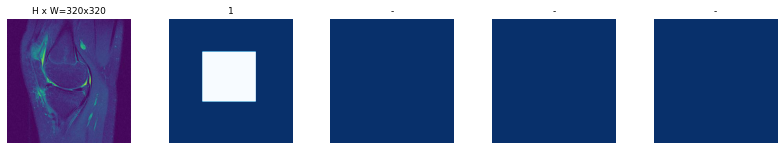

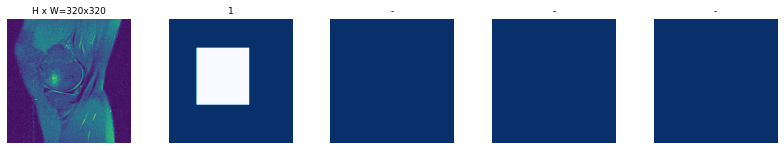

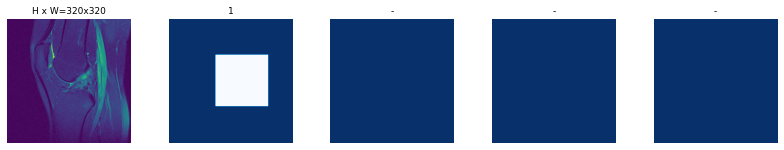

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    
    vis.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=4)

In [6]:
dataset_train.class_names

['BG', '1']

## 3. Training Mrcnn

In [7]:
from mrcnn.config import Config

# Your trained weights will be save here 
WEIGHTS_DIR = "/media/sohaib/additional_/maskrcnn/weights/"

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes + 1
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10


# mention your class and steps here
config = GenericConfig(1, 1000)


model = modellib.MaskRCNN(mode="training", config=config, model_dir=WEIGHTS_DIR)
                



Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


### We will use Image-net weights for transfer learn

In [8]:

# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:

model.train(dataset_train, dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=1000,
        layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /media/sohaib/additional_/maskrcnn/weights/class20210905T1457/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000


/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), va

1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 0.6151 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.2960

/home/sohaib/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1000/1000 [==============================] - 158s 143ms/step - batch: 499.5000 - size: 1.0000 - loss: 0.6151 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.2960 - val_loss: 0.5163 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.0792 - val_mrcnn_class_loss: 0.0912 - val_mrcnn_bbox_loss: 0.1024 - val_mrcnn_mask_loss: 0.2406
Epoch 2/1000
1000/1000 [==============================] - 120s 120ms/step - batch: 499.5000 - size: 1.0000 - loss: 0.2867 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1640 - val_loss: 0.5581 - val_rpn_class_loss: 8.4704e-04 - val_rpn_bbox_loss: 0.1380 - val_mrcnn_class_loss: 0.0294 - val_mrcnn_bbox_loss: 0.1042 - val_mrcnn_mask_loss: 0.2857
Epoch 3/1000
1000/1000 [==============================] - 120s 120ms/step - batch: 499.5000 - size: 1.0000 - loss: 0.2459 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0394 - mr